# Colab A1 — From-scratch Deep Neural Network (3 hidden layers) for Non-Linear Regression  
**Key requirements satisfied:**  
- Synthetic **3-variable** non-linear equation (x1, x2, x3 → y)  
- **Deep** network with **3 hidden layers**  
- **Manual backprop (chain rule)** — no autograd / no `GradientTape`  
- Linear algebra uses **`tf.einsum`** (no `@` / `matmul`)  
- Shows **loss vs epochs** + **final predicted vs true**  
- “4D plot” using **PCA** (X:3D → 2D) then plot (PC1, PC2, y) with color = x3  

> Note: We use **NumPy** for data generation/preprocessing. We use **TensorFlow tensors/variables only** to meet the `tf.einsum` requirement and to store/update weights. Gradients are still computed **manually**.


In [1]:
# =========================
# Cell 1 — Setup
# =========================
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

np.random.seed(7)
tf.random.set_seed(7)


In [2]:
# =========================
# Cell 2 — Synthetic data (3 variables) + preprocessing
# =========================
N = 2000
X = np.random.uniform(-2.0, 2.0, size=(N, 3)).astype(np.float32)
x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]

# 3-variable non-linear target equation + noise
noise = 0.10 * np.random.randn(N).astype(np.float32)
y = (
    np.sin(x1)
    + 0.5 * np.cos(x2 * x3)
    + 0.30 * (x2 ** 2)
    - 0.20 * (x3 ** 3)
    + 0.25 * np.sin(x1 * x2)
    + noise
).astype(np.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Standardize inputs (and targets) for easier optimization
X_mu, X_std = X_train.mean(axis=0, keepdims=True), X_train.std(axis=0, keepdims=True) + 1e-8
y_mu, y_std = y_train.mean(axis=0, keepdims=True), y_train.std(axis=0, keepdims=True) + 1e-8

X_train_n = (X_train - X_mu) / X_std
X_test_n  = (X_test  - X_mu) / X_std
y_train_n = (y_train - y_mu) / y_std
y_test_n  = (y_test  - y_mu) / y_std

print("Shapes:", X_train_n.shape, y_train_n.shape, X_test_n.shape, y_test_n.shape)


Shapes: (1600, 3) (1600, 1) (400, 3) (400, 1)


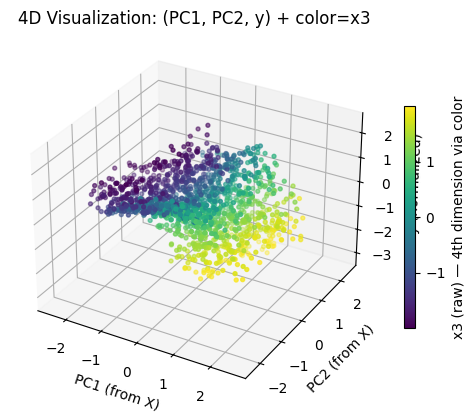

In [3]:
# =========================
# Cell 3 — 4D plot via PCA reduction (3D X -> 2D) + 3D scatter
# =========================
pca = PCA(n_components=2, random_state=7)
X2 = pca.fit_transform(X_train_n)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# 3D axes: PC1, PC2, y  |  Color: original x3 (4th dimension idea)
sc = ax.scatter(X2[:, 0], X2[:, 1], y_train_n[:, 0], c=X_train[:, 2], s=8)
ax.set_xlabel("PC1 (from X)")
ax.set_ylabel("PC2 (from X)")
ax.set_zlabel("y (normalized)")
fig.colorbar(sc, ax=ax, shrink=0.6, label="x3 (raw) — 4th dimension via color")
plt.title("4D Visualization: (PC1, PC2, y) + color=x3")
plt.show()


In [4]:
# =========================
# Cell 4 — 3-hidden-layer NN (from scratch) using tf.einsum
# =========================
def init_var(shape, scale=0.1):
    w = np.random.randn(*shape).astype(np.float32) * scale
    return tf.Variable(w)

# 3 hidden layers (deep)
H1, H2, H3 = 32, 32, 16
W1, b1 = init_var((3,  H1)), tf.Variable(tf.zeros([H1], dtype=tf.float32))
W2, b2 = init_var((H1, H2)), tf.Variable(tf.zeros([H2], dtype=tf.float32))
W3, b3 = init_var((H2, H3)), tf.Variable(tf.zeros([H3], dtype=tf.float32))
W4, b4 = init_var((H3, 1 )), tf.Variable(tf.zeros([1],  dtype=tf.float32))

def relu(z): return tf.maximum(z, 0.0)
def drelu(z): return tf.cast(z > 0.0, tf.float32)
def tanh(z): return tf.tanh(z)
def dtanh_from_a(a): return 1.0 - tf.square(a)  # derivative using activation output

def forward(Xb):
    # Linear layers must use tf.einsum (no matmul/@)
    Z1 = tf.einsum("bi,ij->bj", Xb, W1) + b1
    A1 = tanh(Z1)

    Z2 = tf.einsum("bi,ij->bj", A1, W2) + b2
    A2 = relu(Z2)

    Z3 = tf.einsum("bi,ij->bj", A2, W3) + b3
    A3 = tanh(Z3)

    Yhat = tf.einsum("bi,ij->bj", A3, W4) + b4  # linear output
    cache = (Xb, Z1, A1, Z2, A2, Z3, A3, Yhat)
    return Yhat, cache


Epoch   1 | Loss (MSE, normalized): 0.997478
Epoch  50 | Loss (MSE, normalized): 0.180422
Epoch 100 | Loss (MSE, normalized): 0.131124
Epoch 150 | Loss (MSE, normalized): 0.081987
Epoch 200 | Loss (MSE, normalized): 0.060197
Epoch 250 | Loss (MSE, normalized): 0.051025
Epoch 300 | Loss (MSE, normalized): 0.045546


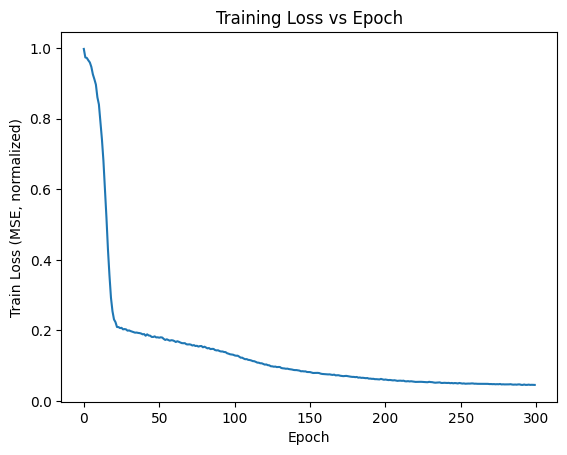

In [5]:
# =========================
# Cell 5 — Manual backprop + training loop (SGD)
# =========================
def mse(yhat, ytrue):
    return tf.reduce_mean(tf.square(yhat - ytrue))

def train_step(Xb, yb, lr):
    Yhat, (Xb, Z1, A1, Z2, A2, Z3, A3, Yhat) = forward(Xb)
    B = tf.cast(tf.shape(Xb)[0], tf.float32)
    loss = mse(Yhat, yb)

    # dLoss/dYhat for MSE: (2/B) * (Yhat - y)
    dY = (2.0 / B) * (Yhat - yb)  # (B,1)

    # Layer 4 grads
    dW4 = tf.einsum("bi,bj->ij", A3, dY)              # (H3,1)
    db4 = tf.reduce_sum(dY, axis=0)                   # (1,)
    dA3 = tf.einsum("bo,ho->bh", dY, W4)              # (B,H3)

    # Layer 3 grads (tanh)
    dZ3 = dA3 * dtanh_from_a(A3)                      # (B,H3)
    dW3 = tf.einsum("bi,bj->ij", A2, dZ3)             # (H2,H3)
    db3 = tf.reduce_sum(dZ3, axis=0)                  # (H3,)
    dA2 = tf.einsum("bk,ik->bi", dZ3, W3)             # (B,H2)

    # Layer 2 grads (ReLU)
    dZ2 = dA2 * drelu(Z2)                             # (B,H2)
    dW2 = tf.einsum("bi,bj->ij", A1, dZ2)             # (H1,H2)
    db2 = tf.reduce_sum(dZ2, axis=0)                  # (H2,)
    dA1 = tf.einsum("bk,ik->bi", dZ2, W2)             # (B,H1)

    # Layer 1 grads (tanh)
    dZ1 = dA1 * dtanh_from_a(A1)                      # (B,H1)
    dW1 = tf.einsum("bi,bj->ij", Xb, dZ1)             # (3,H1)
    db1 = tf.reduce_sum(dZ1, axis=0)                  # (H1,)

    # SGD update
    W1.assign_sub(lr * dW1); b1.assign_sub(lr * db1)
    W2.assign_sub(lr * dW2); b2.assign_sub(lr * db2)
    W3.assign_sub(lr * dW3); b3.assign_sub(lr * db3)
    W4.assign_sub(lr * dW4); b4.assign_sub(lr * db4)

    return float(loss.numpy())

# Training config
epochs = 300
batch_size = 128
lr = 0.01

Xtr = tf.constant(X_train_n, dtype=tf.float32)
ytr = tf.constant(y_train_n, dtype=tf.float32)

losses = []
n = X_train_n.shape[0]

for ep in range(1, epochs + 1):
    idx = np.random.permutation(n)
    ep_loss = 0.0
    steps = 0

    for start in range(0, n, batch_size):
        batch_idx = idx[start:start + batch_size]
        Xb = tf.gather(Xtr, batch_idx)
        yb = tf.gather(ytr, batch_idx)
        ep_loss += train_step(Xb, yb, lr)
        steps += 1

    ep_loss /= steps
    losses.append(ep_loss)

    if ep % 50 == 0 or ep == 1:
        print(f"Epoch {ep:3d} | Loss (MSE, normalized): {ep_loss:.6f}")

plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss (MSE, normalized)")
plt.title("Training Loss vs Epoch")
plt.show()


Test MSE (normalized): 0.045898
Test MSE (original scale): 0.049463


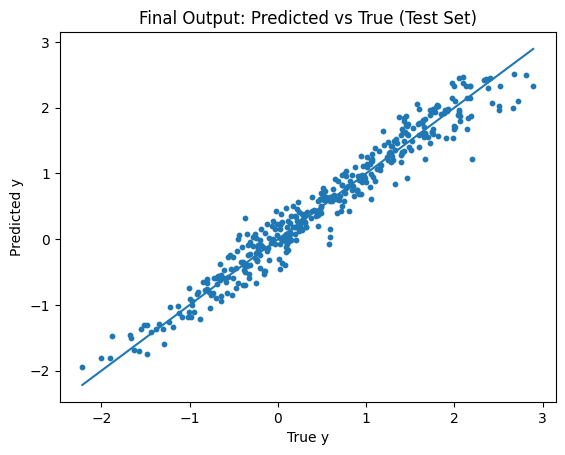

Sample 0: true= 0.0281 | pred=-0.0778
Sample 1: true= 1.2483 | pred= 1.4728
Sample 2: true=-0.7661 | pred=-1.0403
Sample 3: true= 1.8116 | pred= 2.0269
Sample 4: true= 1.6677 | pred= 1.8238


In [6]:
# =========================
# Cell 6 — Final output: test evaluation + plots
# =========================
Xte = tf.constant(X_test_n, dtype=tf.float32)
yte = tf.constant(y_test_n, dtype=tf.float32)

yhat_n, _ = forward(Xte)
test_mse_n = float(tf.reduce_mean(tf.square(yhat_n - yte)).numpy())

# Unnormalize for human-readable scale
yhat = (yhat_n.numpy() * y_std + y_mu).reshape(-1, 1)
ytrue = y_test

test_mse = float(np.mean((yhat - ytrue) ** 2))
print(f"Test MSE (normalized): {test_mse_n:.6f}")
print(f"Test MSE (original scale): {test_mse:.6f}")

# Pred vs True plot
plt.figure()
plt.scatter(ytrue, yhat, s=10)
mn, mx = float(ytrue.min()), float(ytrue.max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Final Output: Predicted vs True (Test Set)")
plt.show()

# Show a few samples
for i in range(5):
    print(f"Sample {i}: true={ytrue[i,0]: .4f} | pred={yhat[i,0]: .4f}")
